In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score)

In [28]:
# Load and shuffle data to prevent ordered outcomes
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data_final.csv')
data.head(2)

,# FP1-F7_mean,C3-P3_mean,C4-P4_mean,CZ-PZ_mean,F3-C3_mean,F4-C4_mean,F7-T7_mean,F8-T8_mean,FP1-F3_mean,FP2-F4_mean,...,P3-O1_line_length,P4-O2_line_length,P7-O1_line_length,P7-T7_line_length,P8-O2_line_length,T7-FT9_line_length,T7-P7_line_length,T8-P8-0_line_length,T8-P8-1_line_length,target
0,-0.000006,2.430477e-06,0.000007,2.915313e-07,0.000004,-0.000003,-1.960824e-06,0.000007,-0.000007,6.283437e-07,...,0.001057,0.001571,0.000693,0.000457,0.002003,0.001435,0.000457,0.000554,0.000554,0
1,-0.000004,6.301407e-07,0.000005,-1.961703e-06,-0.000002,-0.000005,7.762930e-07,0.000005,-0.000004,-8.191211e-06,...,0.001071,0.001638,0.000780,0.000531,0.002078,0.001436,0.000531,0.000588,0.000588,0


In [29]:
# Verify class distribution after shuffling
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print("Class distribution after shuffling:")
print(data['target'].value_counts(normalize=True))
data.head(2)

Class distribution after shuffling:
target
1    0.500061
0    0.499939
Name: proportion, dtype: float64


,# FP1-F7_mean,C3-P3_mean,C4-P4_mean,CZ-PZ_mean,F3-C3_mean,F4-C4_mean,F7-T7_mean,F8-T8_mean,FP1-F3_mean,FP2-F4_mean,...,P3-O1_line_length,P4-O2_line_length,P7-O1_line_length,P7-T7_line_length,P8-O2_line_length,T7-FT9_line_length,T7-P7_line_length,T8-P8-0_line_length,T8-P8-1_line_length,target
0,-0.000009,0.000002,-0.000006,0.000006,-0.000005,-0.000002,-0.000023,-2.917930e-07,-0.000030,-0.000016,...,0.001755,0.003191,0.005120,0.008812,0.006916,0.007487,0.008811,0.007215,0.007215,1
1,-0.000027,-0.000034,0.000002,-0.000007,-0.000008,0.000009,-0.000002,5.838319e-07,-0.000034,-0.000016,...,0.002725,0.003510,0.003098,0.008251,0.003259,0.009045,0.008251,0.004289,0.004289,0


In [30]:
# Split features and target
X = data.drop('target', axis=1)
y = data['target']

In [31]:
# First split: 80% train-val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
)

print(f"\nTrain-val size: {len(X_trainval)}, Test size: {len(X_test)}")
print("Test set class distribution:", np.unique(y_test, return_counts=True))


Train-val size: 13105, Test size: 3277
Test set class distribution: (array([0, 1]), array([1638, 1639]))


In [32]:
# Extended parameter grid for better exploration
param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10],
    'gamma': ['scale'],
    'class_weight': ['balanced']
}

# Configure grid search with inner CV
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)

# Train on train-val data only
grid_search.fit(X_trainval, y_trainval)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10], 'class_weight': ['balanced'],
                         'gamma': ['scale'], 'kernel': ['rbf']},
             scoring='accuracy')


=== Best Model Test Set Performance ===
Accuracy: 0.9051

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1638
           1       0.91      0.89      0.90      1639

    accuracy                           0.91      3277
   macro avg       0.91      0.91      0.91      3277
weighted avg       0.91      0.91      0.91      3277



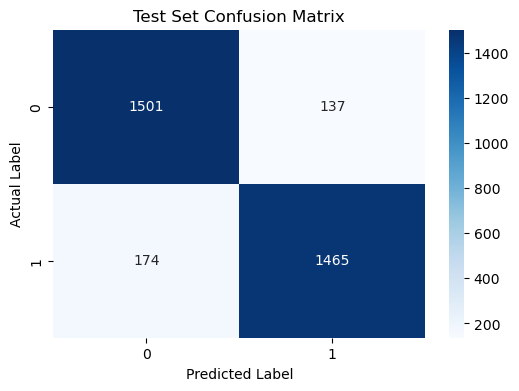

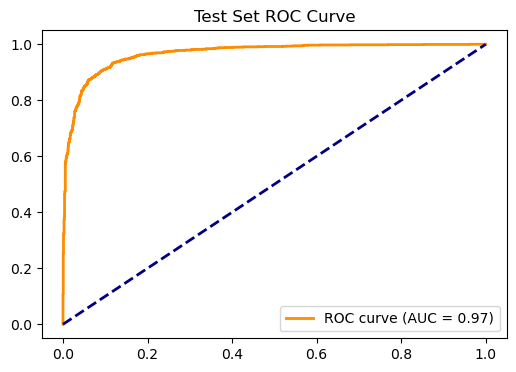

In [33]:
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Best Model Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Test Set ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
# For robust performance estimation
print("\n=== Nested Cross-Validation ===")
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

nested_scores = []
for train_idx, test_idx in outer_cv.split(X_trainval, y_trainval):
    grid_search_nested = GridSearchCV(
        SVC(probability=True, random_state=42),
        param_grid,
        cv=inner_cv,
        n_jobs=-1
    )
    grid_search_nested.fit(X_trainval.iloc[train_idx], y_trainval.iloc[train_idx])
    nested_scores.append(grid_search_nested.score(
        X_trainval.iloc[test_idx], y_trainval.iloc[test_idx]
    ))

print(f"Nested CV Accuracy: {np.mean(nested_scores):.4f} (±{np.std(nested_scores):.4f})")


=== Nested Cross-Validation ===
Nested CV Accuracy: 0.8924 (±0.0044)


In [35]:
print("\n=== Optimal Parameters ===")
print(grid_search.best_params_)

# Retrain on combined train-val data
final_model = grid_search.best_estimator_.fit(X_trainval, y_trainval)


=== Optimal Parameters ===
{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
